In [4]:
import numpy as np
import matplotlib.pyplot as plt
import gudhi as gd

sampled_data = np.load('dragon_vrip_sampled_500.npy')

print(f"Loaded data shape: {sampled_data.shape}")
num_points_loaded = sampled_data.shape[0]

# 1. Define the points for the Rips Complex
# For Rips, the entire sampled dataset serves as the input.
points = sampled_data

if num_points_loaded == 0:
    print("Error: No points loaded to create a complex.")
    # Exit or handle error appropriately if no points are loaded
else:
    # 2. Determine max_edge_length
    # This value is crucial for Rips. It defines the maximum distance between any two points that will form an edge in the complex.
    # Higher values will lead to larger, denser complexes.
    # A heuristic to estimate `max_alpha_value` is to consider a fraction of the data's overall range or diameter

    min_coords = np.min(points, axis=0)
    max_coords = np.max(points, axis=0)
    data_range = np.linalg.norm(max_coords - min_coords) # Diagonal length of bounding box
    
    # A common starting point: 5-10% of the data range.
    # Rips can explode quickly, so start smaller than with Witness complexes.
    estimated_max_edge_length = data_range * 0.05
    
    # Fallback for very small or zero range
    if estimated_max_edge_length < 1e-6:
        estimated_max_edge_length = 1.0 

    max_edge_length = estimated_max_edge_length # Adjust this value based on your data and needs

    print(f"Total points loaded: {num_points_loaded}")
    print(f"Estimated data range: {data_range:.2f}")
    print(f"Using max_edge_length: {max_edge_length:.2f}")

    try:
        # 3. Create the Rips Complex instance
        rips_complex = gd.RipsComplex(
            points=points,
            max_edge_length=max_edge_length # The critical parameter
        )

        # 4. Create the Simplex Tree from the Rips complex
        # This step actually builds the simplicial complex up to the specified dimension.
        # By default, create_simplex_tree will build up to the maximum possible dimension implied by the number of points and max_edge_length.
        simplex_tree_rips = rips_complex.create_simplex_tree(max_dimension=2)

        print("\n--- Vietoris-Rips Complex Information ---")
        print(f"Successfully created a Vietoris-Rips Complex.")
        print(f"Number of simplices in the complex: {simplex_tree_rips.num_simplices()}")
        print(f"Dimension of the complex: {simplex_tree_rips.dimension()}")

        # # You can now use `simplex_tree_rips` for further topological data analysis,
        # # such as computing persistent homology:
        # print("\nComputing persistent homology...")
        # persistence_rips = simplex_tree_rips.persistence(persistence_dim_max=True)
        # print(f"Number of persistence pairs: {len(persistence_rips)}")

        # # Plot the persistence diagram
        # if len(persistence_rips) > 0:
        #     print("Plotting persistence diagram...")
        #     gd.plot_persistence_diagram(persistence_rips)
        #     plt.title(f"Persistence Diagram (Max Edge Length: {max_edge_length:.2f})")
        #     plt.show()
        #     print("Plotting persistence barcode...")
        #     gd.plot_persistence_barcode(persistence_rips)
        #     plt.title(f"Persistence Barcode (Max Edge Length: {max_edge_length:.2f})")
        #     plt.show()
        # else:
        #     print("No persistence pairs found for Rips Complex (complex might be too sparse).")

    except Exception as e:
        print(f"\nAn error occurred while creating the Rips Complex: {e}")
        print("This often happens if 'max_edge_length' is too small, or the data is not suitable.")

Loaded data shape: (500, 3)
Total points loaded: 500
Estimated data range: 0.26
Using max_edge_length: 0.01

--- Vietoris-Rips Complex Information ---
Successfully created a Vietoris-Rips Complex.
Number of simplices in the complex: 3065
Dimension of the complex: 2


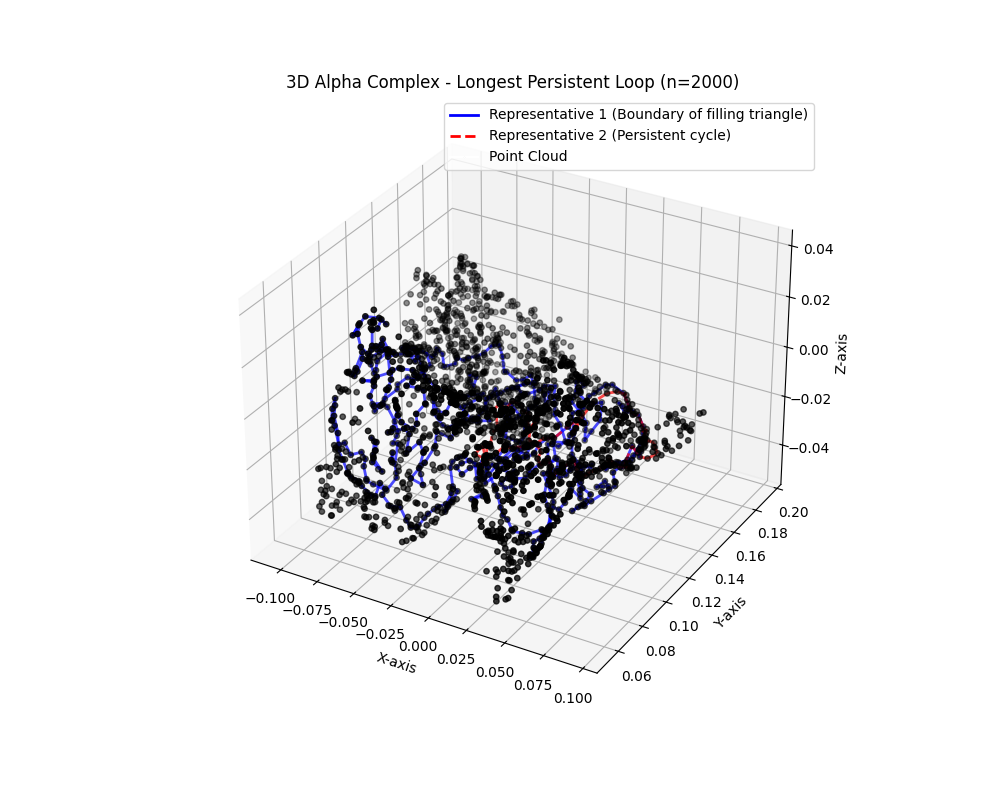

<Axes: title={'center': 'Persistence barcode'}>

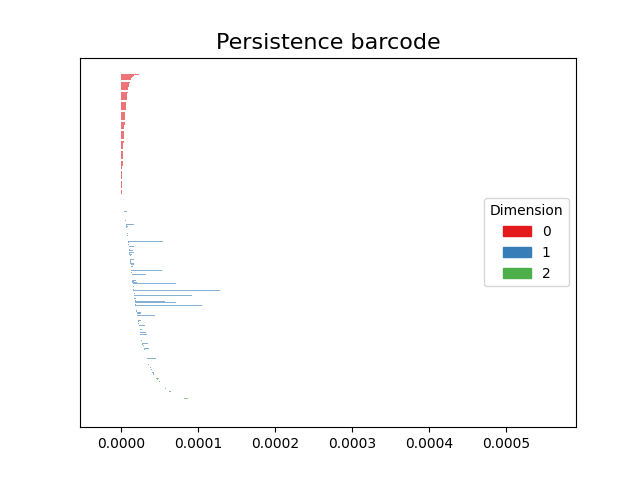

In [16]:
import gudhi
import itertools
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # Required for 3D projection
%matplotlib widget

# 1. Generate 3D points
points = np.load('dragon_vrip_sampled_2000.npy')
n = points.shape[0] # Reduced n for better 3D visualization, can be increased

# Gudhi Alpha Complex and persistence calculation (mostly unchanged)
gudhi_complex = gudhi.AlphaComplex(points).create_simplex_tree()
alpha_complex = {tuple(sorted(simplex)) : radius for simplex, radius in gudhi_complex.get_filtration()}
boundary_matrix = {simplex : set(itertools.combinations(simplex, len(simplex)-1))-{tuple()} for simplex in alpha_complex}

R = { k : v for k,v in boundary_matrix.items()}
V = { k : {k} for k in boundary_matrix}
lowinv = {} # lowinv[i]=index of column with the lowest 1 at i
order_function = lambda s: (alpha_complex[s], s) # Filtration value first, then simplex for tie-breaking

# Sort simplices by filtration value and then lexicographically
sorted_simplices = sorted(R.keys(), key=order_function)

for s in sorted_simplices:
    # Ensure R[s] is not empty before calling max
    if R[s]:
        # max_boundary_simplex = max(R[s], key=order_function) # Original
        # Use a default for max if R[s] is empty to avoid error, or handle explicitly
        # The lambda for max should only be applied if R[s] is not empty
        t = lowinv.get(max(R[s], key=order_function), -1)
    else:
        t = -1

    while t != -1:
        R[s] = R[t]^R[s] # symmetric difference of t-th and s-th columns
        V[s] = V[t]^V[s]
        if R[s]: # Check again if R[s] is not empty after symmetric difference
            t = lowinv.get(max(R[s], key=order_function), -1)
        else:
            t = -1 # R[s] became empty, stop iteration for this s
            
    if R[s]: # If R[s] is not empty after reduction
        lowinv[max(R[s], key=order_function)] = s

# Identify loops (1-dimensional homology)
# A bar (birth_simplex, death_simplex) corresponds to a loop if birth_simplex is an edge (len=2)
# and death_simplex is a triangle (len=3) whose boundary "kills" the edge.
# In the standard persistence algorithm, lowinv maps a (d-1)-simplex (birth) to the d-simplex (death) that kills it.
# So, we are looking for (edge, triangle) pairs.
loops = [(birth_simplex, death_simplex) for birth_simplex, death_simplex in lowinv.items() if len(birth_simplex) == 2]

if not loops:
    print("No 1-dimensional loops found.")
else:
    # Find the longest loop based on persistence (death_time - birth_time)
    longest_loop = max(loops, key=lambda bar: alpha_complex[bar[1]] - alpha_complex[bar[0]])
    
    # representative_1 is R[death_simplex_of_longest_loop]
    # This is the boundary of the triangle that filled the hole.
    # It should be a cycle homologous to the original one.
    representative_1_edges = R[longest_loop[1]]
    
    # representative_2 is V[birth_simplex_of_longest_loop]
    # This is the original cycle (a sum of simplices) that was "killed".
    representative_2_edges = set()
    # V[birth_simplex] contains simplices whose sum forms the cycle.
    # We are interested in the 1-simplices (edges) in this sum.
    for simplex_in_V in V[longest_loop[0]]:
        if len(simplex_in_V) == 2: # Ensure it's an edge
            representative_2_edges.add(simplex_in_V)

    # 2. Setup 3D plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot representative 1 (boundary of the filling triangle)
    for edge_indices in representative_1_edges:
        # Ensure we have valid indices and they form an edge
        if len(edge_indices) == 2 and all(idx < n for idx in edge_indices):
            p1 = points[edge_indices[0]]
            p2 = points[edge_indices[1]]
            ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], '-', color='blue', alpha=0.7, linewidth=2)


    # Plot representative 2 (the original persistent cycle)
    for edge_indices in representative_2_edges:
        if len(edge_indices) == 2 and all(idx < n for idx in edge_indices):
            p1 = points[edge_indices[0]]
            p2 = points[edge_indices[1]]
            ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], '--', color='red', alpha=0.7, linewidth=2)

    # Plot the point cloud
    x_coords = [p[0] for p in points]
    y_coords = [p[1] for p in points]
    z_coords = [p[2] for p in points]
    ax.scatter(x_coords, y_coords, z_coords, c='black', marker='o', s=15, label="Point Cloud")

    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.set_zlabel("Z-axis")
    ax.set_title(f"3D Alpha Complex - Longest Persistent Loop (n={n})")
    
    # Create dummy lines for legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='blue', lw=2, label='Representative 1 (Boundary of filling triangle)'),
        Line2D([0], [0], color='red', linestyle='--', lw=2, label='Representative 2 (Persistent cycle)'),
        Line2D([0], [0], marker='o', color='w', label='Point Cloud',
               markerfacecolor='black', markersize=1)
    ]
    ax.legend(handles=legend_elements, loc='best')

    plt.show()
persistence_diagram = gudhi_complex.persistence()
gudhi.plot_persistence_barcode(persistence_diagram)

<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

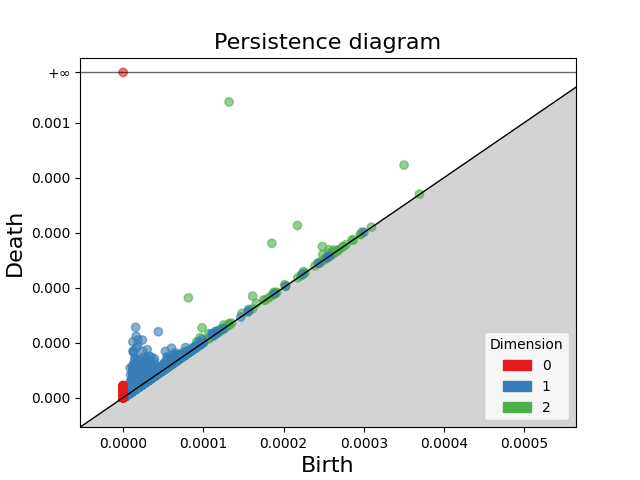

In [17]:
gudhi.plot_persistence_diagram(persistence_diagram)

In [21]:
dir(gudhi_complex)

['__class__',
 '__deepcopy__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__pyx_fuse_0_0insert_batch',
 '__pyx_fuse_0_1insert_batch',
 '__pyx_fuse_1_0insert_batch',
 '__pyx_fuse_1_1insert_batch',
 '__pyx_vtable__',
 '__reduce__',
 '__reduce_cython__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__setstate_cython__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '_is_defined',
 '_is_persistence_defined',
 'assign_filtration',
 'betti_numbers',
 'collapse_edges',
 'compute_persistence',
 'copy',
 'create_from_array',
 'dimension',
 'expansion',
 'expansion_with_blocker',
 'extend_filtration',
 'extended_persistence',
 'filtration',
 'find',
 'flag_persistence_generators',
 'get_boundaries',
 'get_cofaces',
 'get_filtration',
 'get_simplices',
 'get_skeleton',
 'get_star',
 'initialize_fil

Loaded data shape: (500, 3)
Total points loaded: 500
Estimated data range: 0.26
Using max_edge_length: 0.01

--- Vietoris-Rips Complex Information ---
Successfully created a Vietoris-Rips Complex.
Number of simplices in the complex: 3065
Dimension of the complex: 2

Computing persistent homology...
Number of persistence pairs: 1171
Plotting persistence diagram...


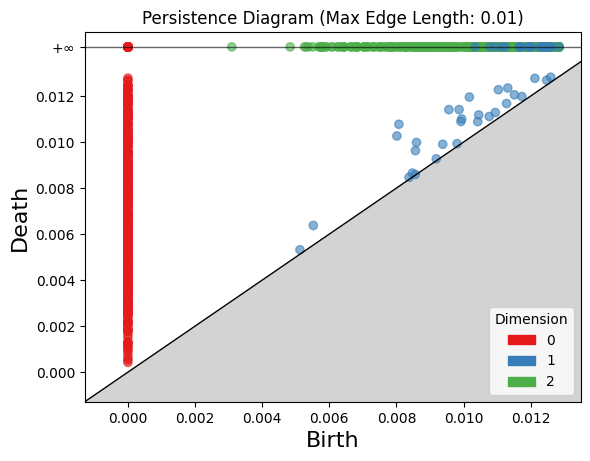

Loaded data shape: (1000, 3)
Total points loaded: 1000
Estimated data range: 0.26
Using max_edge_length: 0.01

--- Vietoris-Rips Complex Information ---
Successfully created a Vietoris-Rips Complex.
Number of simplices in the complex: 17492
Dimension of the complex: 2

Computing persistent homology...
Number of persistence pairs: 8715
Plotting persistence diagram...


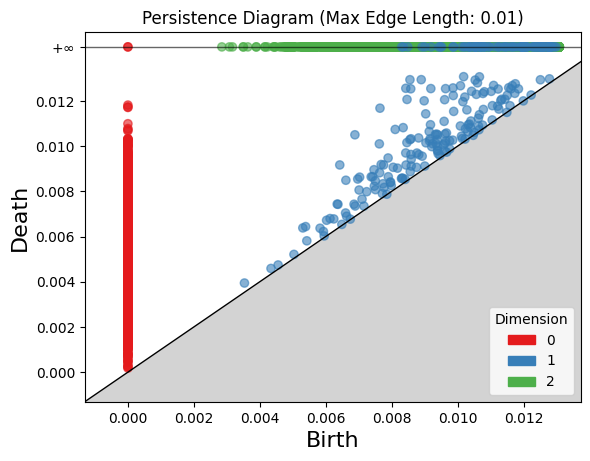

Loaded data shape: (1500, 3)
Total points loaded: 1500
Estimated data range: 0.26
Using max_edge_length: 0.01

--- Vietoris-Rips Complex Information ---
Successfully created a Vietoris-Rips Complex.
Number of simplices in the complex: 57616
Dimension of the complex: 2

Computing persistent homology...
Number of persistence pairs: 35870
Plotting persistence diagram...


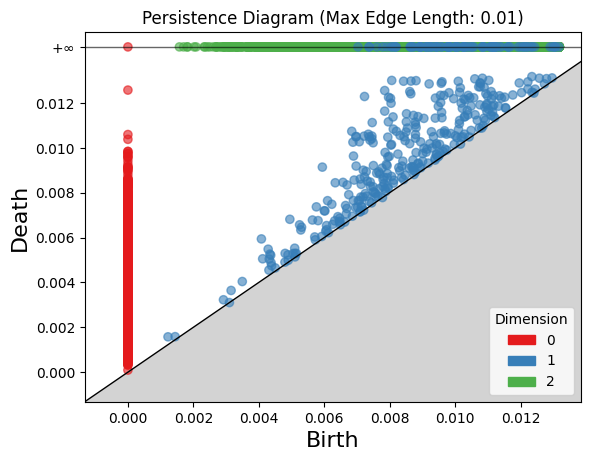

Loaded data shape: (2000, 3)
Total points loaded: 2000
Estimated data range: 0.26
Using max_edge_length: 0.01

--- Vietoris-Rips Complex Information ---
Successfully created a Vietoris-Rips Complex.
Number of simplices in the complex: 121459
Dimension of the complex: 2

Computing persistent homology...
Number of persistence pairs: 82824
Plotting persistence diagram...


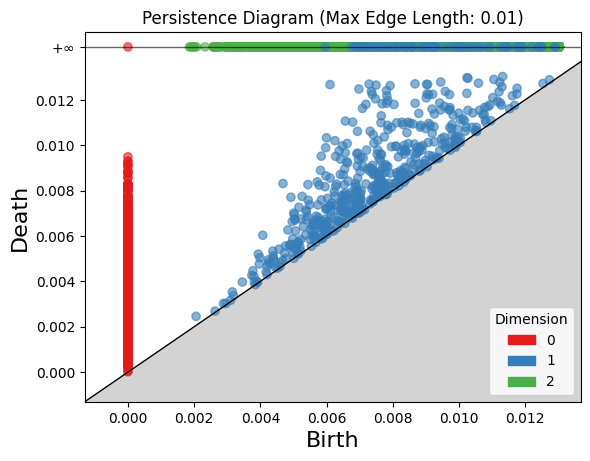

Loaded data shape: (2500, 3)
Total points loaded: 2500
Estimated data range: 0.26
Using max_edge_length: 0.01

--- Vietoris-Rips Complex Information ---
Successfully created a Vietoris-Rips Complex.
Number of simplices in the complex: 212739
Dimension of the complex: 2

Computing persistent homology...
Number of persistence pairs: 152776
Plotting persistence diagram...


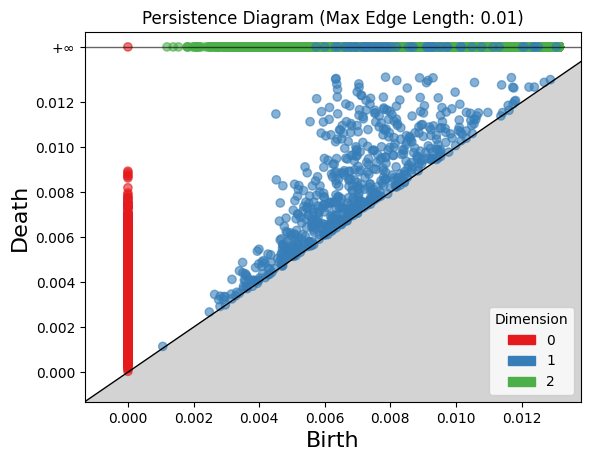

Loaded data shape: (3000, 3)
Total points loaded: 3000
Estimated data range: 0.26
Using max_edge_length: 0.01

--- Vietoris-Rips Complex Information ---
Successfully created a Vietoris-Rips Complex.
Number of simplices in the complex: 394649
Dimension of the complex: 2

Computing persistent homology...
Number of persistence pairs: 303532
Plotting persistence diagram...


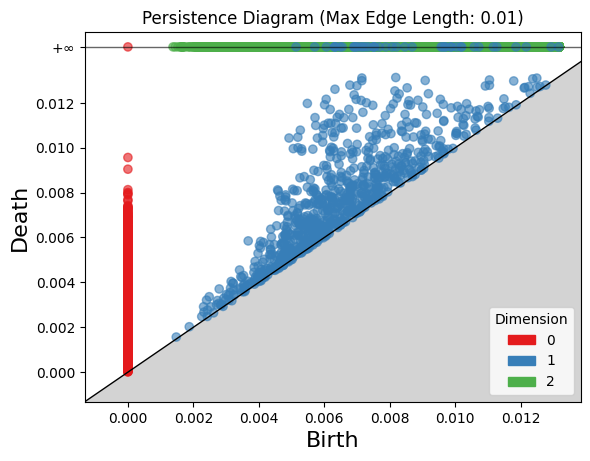

Loaded data shape: (3500, 3)
Total points loaded: 3500
Estimated data range: 0.26
Using max_edge_length: 0.01

--- Vietoris-Rips Complex Information ---
Successfully created a Vietoris-Rips Complex.
Number of simplices in the complex: 607858
Dimension of the complex: 2

Computing persistent homology...
Number of persistence pairs: 483319
Plotting persistence diagram...


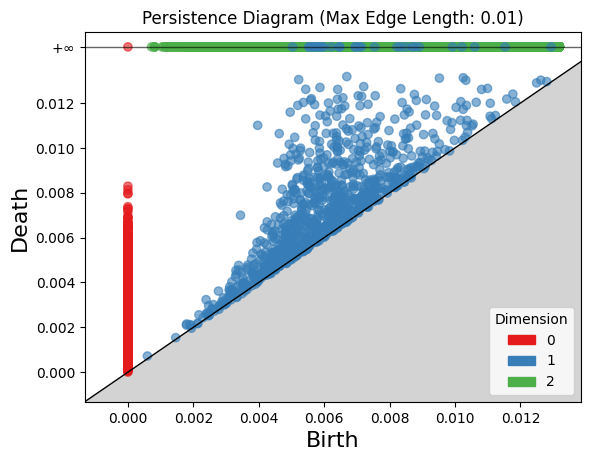

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import gudhi as gd

samples = [
    ('sampled_500', np.load('dragon_vrip_sampled_500.npy')),
    ('sampled_1000', np.load('dragon_vrip_sampled_1000.npy')),
    ('sampled_1500', np.load('dragon_vrip_sampled_1500.npy')),
    ('sampled_2000', np.load('dragon_vrip_sampled_2000.npy')),
    ('sampled_2500', np.load('dragon_vrip_sampled_2500.npy')),
    ('sampled_3000', np.load('dragon_vrip_sampled_3000.npy')),
    ('sampled_3500', np.load('dragon_vrip_sampled_3500.npy'))
]

for name, points in samples:

    print(f"Loaded data shape: {points.shape}")
    num_points_loaded = points.shape[0]

    if num_points_loaded == 0:
        print("Error: No points loaded to create a complex.")
        # Exit or handle error appropriately if no points are loaded
    else:
        # 2. Determine max_edge_length
        # This value is crucial for Rips. It defines the maximum distance between any two points that will form an edge in the complex.
        # Higher values will lead to larger, denser complexes.
        # A heuristic to estimate `max_alpha_value` is to consider a fraction of the data's overall range or diameter

        min_coords = np.min(points, axis=0)
        max_coords = np.max(points, axis=0)
        data_range = np.linalg.norm(max_coords - min_coords) # Diagonal length of bounding box
        
        # A common starting point: 5-10% of the data range.
        # Rips can explode quickly, so start smaller than with Witness complexes.
        estimated_max_edge_length = data_range * 0.05
        
        # Fallback for very small or zero range
        if estimated_max_edge_length < 1e-6:
            estimated_max_edge_length = 1.0 

        max_edge_length = estimated_max_edge_length # Adjust this value based on your data and needs

        print(f"Total points loaded: {num_points_loaded}")
        print(f"Estimated data range: {data_range:.2f}")
        print(f"Using max_edge_length: {max_edge_length:.2f}")

        try:
            # 3. Create the Rips Complex instance
            rips_complex = gd.RipsComplex(
                points=points,
                max_edge_length=max_edge_length # The critical parameter
            )

            # 4. Create the Simplex Tree from the Rips complex
            # This step actually builds the simplicial complex up to the specified dimension.
            # By default, create_simplex_tree will build up to the maximum possible dimension implied by the number of points and max_edge_length.
            simplex_tree_rips = rips_complex.create_simplex_tree(max_dimension=2)

            print("\n--- Vietoris-Rips Complex Information ---")
            print(f"Successfully created a Vietoris-Rips Complex.")
            print(f"Number of simplices in the complex: {simplex_tree_rips.num_simplices()}")
            print(f"Dimension of the complex: {simplex_tree_rips.dimension()}")

            # You can now use `simplex_tree_rips` for further topological data analysis, such as computing persistent homology:
            print("\nComputing persistent homology...")
            persistence_rips = simplex_tree_rips.persistence(persistence_dim_max=True)
            print(f"Number of persistence pairs: {len(persistence_rips)}")

            # Plot the persistence diagram
            if len(persistence_rips) > 0:
                print("Plotting persistence diagram...")
                gd.plot_persistence_diagram(persistence_rips)
                plt.title(f"Persistence Diagram (Max Edge Length: {max_edge_length:.2f})")
                plt.show()
            else:
                print("No persistence pairs found for Rips Complex (complex might be too sparse).")

        except Exception as e:
            print(f"\nAn error occurred while creating the Rips Complex: {e}")
            print("This often happens if 'max_edge_length' is too small, or the data is not suitable.")